# A study in encoder filters

## Setup
First we define a runner function to run all of the various tests in a consistent way. The runner takes two arguments:
- Filename of the CSV data file
- A GH estimator object

The GH estimator must implement an `update` method which takes three arguments:
- The time of the sample in seconds
- The encoder's distance measurement
- The encoder's rate measurement

Further, the GH estimator class must keep track of the latest estimate after each update in variables named:
- estDistance
- estRate
- estAccel

The runner will iterate over the data calling `update` for each data point. The resulting estimates for distance and rate will be recorded at each time step. At the conclusion, the runner will display two plots, one each for distance and rate. On each plot will be the encoder measurements as well as the filter's estimate.


In [17]:
from matplotlib import pyplot as plt
import pandas as pd

def runGH(filename, estimator):
    data = pd.read_csv('data-slow-to-stop.csv')

    result = pd.DataFrame({
        'time' : [],
        'dist' : [],
        'rate' : [],
        'estDist' : [],
        'estRate' : [],
        'estAccel' : [],
    })
    for index, row in data.iterrows():
        estimator.update(row.time, row.dist, row.rate)
        result = result.append({
            "time": row.time,
            "dist": row.dist,
            "rate": row.rate,
            "estDist": estimator.estDistance,
            "estRate": estimator.estRate,
            "estAccel": estimator.estAccel,
        }, ignore_index = True)
    return result
    
def plotEstimates(*, data):
    fig, [ax_d, ax_r] = plt.subplots(nrows=2, ncols=1, figsize=(10,16), dpi=145)
    ax_d.plot(data.time, data.dist)
    ax_d.plot(data.time, data.estDist)
    ax_d.set_title('Distance')
    ax_d.legend(['Encoder', 'Estimated'])

    ax_r.set_ylim([0,10])
    ax_r.plot(data.time, data.rate)
    ax_r.plot(data.time, data.estRate)
    ax_r.set_title('Rate')
    ax_r.legend(['Encoder', 'Estimated'])

print("Functions runGH and plotEstimates defined.")


Functions runGH and plotEstimates defined.


## Simple GH filter
This filter is a simple, naive GH filter based on the introductory work [here](http://localhost:8888/notebooks/01-g-h-filter.ipynb).
Lower scale values place more trust in the prediction while higher values place more trust in the measurements.

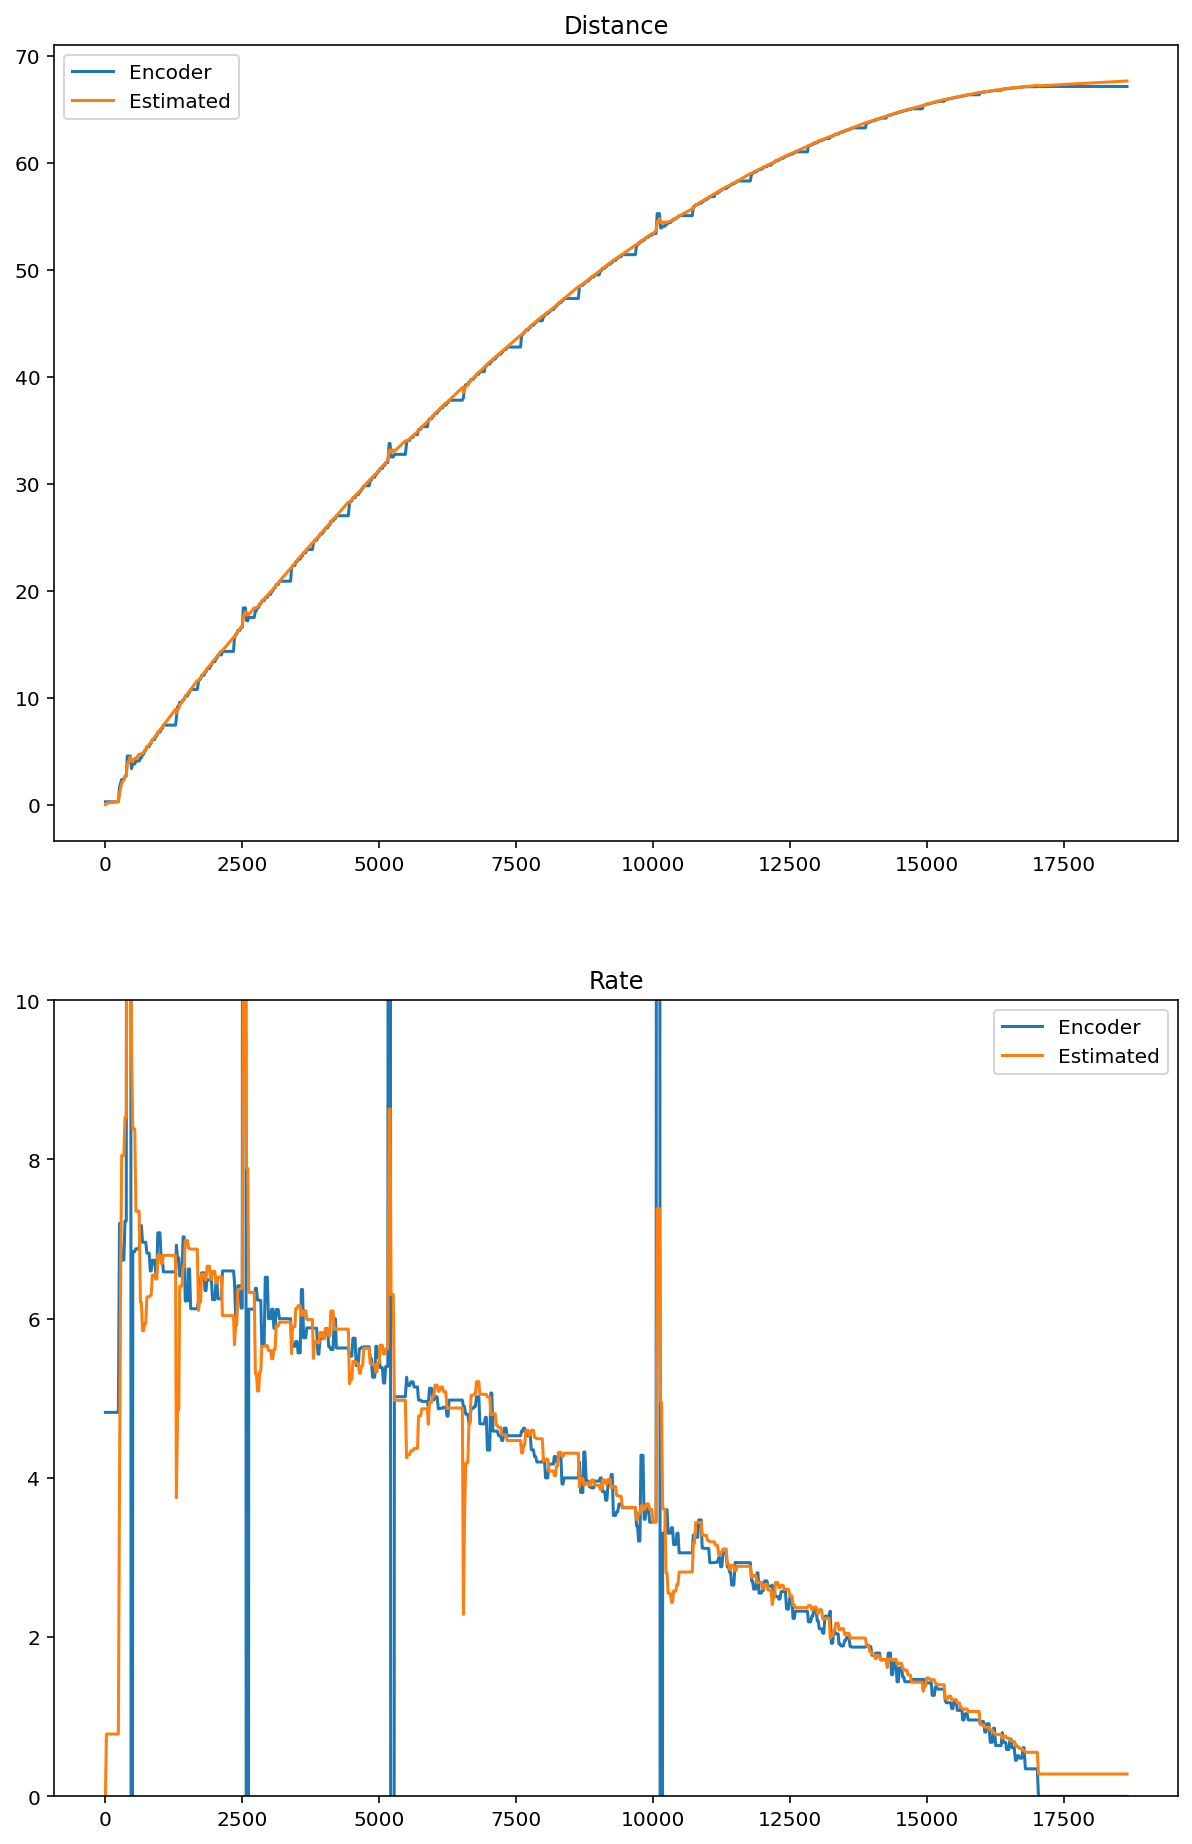

In [77]:
# A simple GH filter based on http://localhost:8888/notebooks/01-g-h-filter.ipynb
class GHEstimator:
    # The time of the last sample and its value
    lastSampleTime = 0.0
    lastEncDistance = 0.0

    # Current estimates for distance, rate, and acceleration
    estDistance = 0.0
    estRate = 0.0
    estAccel = 0.0

    def __init__(self, *, distance_scale, rate_scale):
        self.distance_scale = distance_scale
        self.rate_scale = rate_scale
    
    def update(self, sampleTime, encoderDistance, encoderRate):
        dt = (sampleTime - self.lastSampleTime) / 1000.0

        # Special case, duplicate time value or initial data.
        if dt == 0:
            self.lastSampleTime = sampleTime
            return

        # Prediction step
        predDistance = self.estDistance + self.estRate * dt
        predRate     = self.estRate # Assume rate is constant
        
        # Update step if a new value has arrived
        if encoderDistance != self.lastEncDistance:
            residual = encoderDistance - predDistance

            self.estDistance = predDistance + self.distance_scale * residual
            self.estRate     = predRate     + self.rate_scale     * residual / dt

            self.lastSampleTime = sampleTime
            self.lastEncDistance = encoderDistance
        else:
            self.estDistance = predDistance
            self.estRate     = predRate

        self.lastSampleTime = sampleTime


f = GHEstimator(distance_scale=0.5, rate_scale=0.05)
data = runGH('data-slow-to-stop.csv', f)
plotEstimates(data=data)

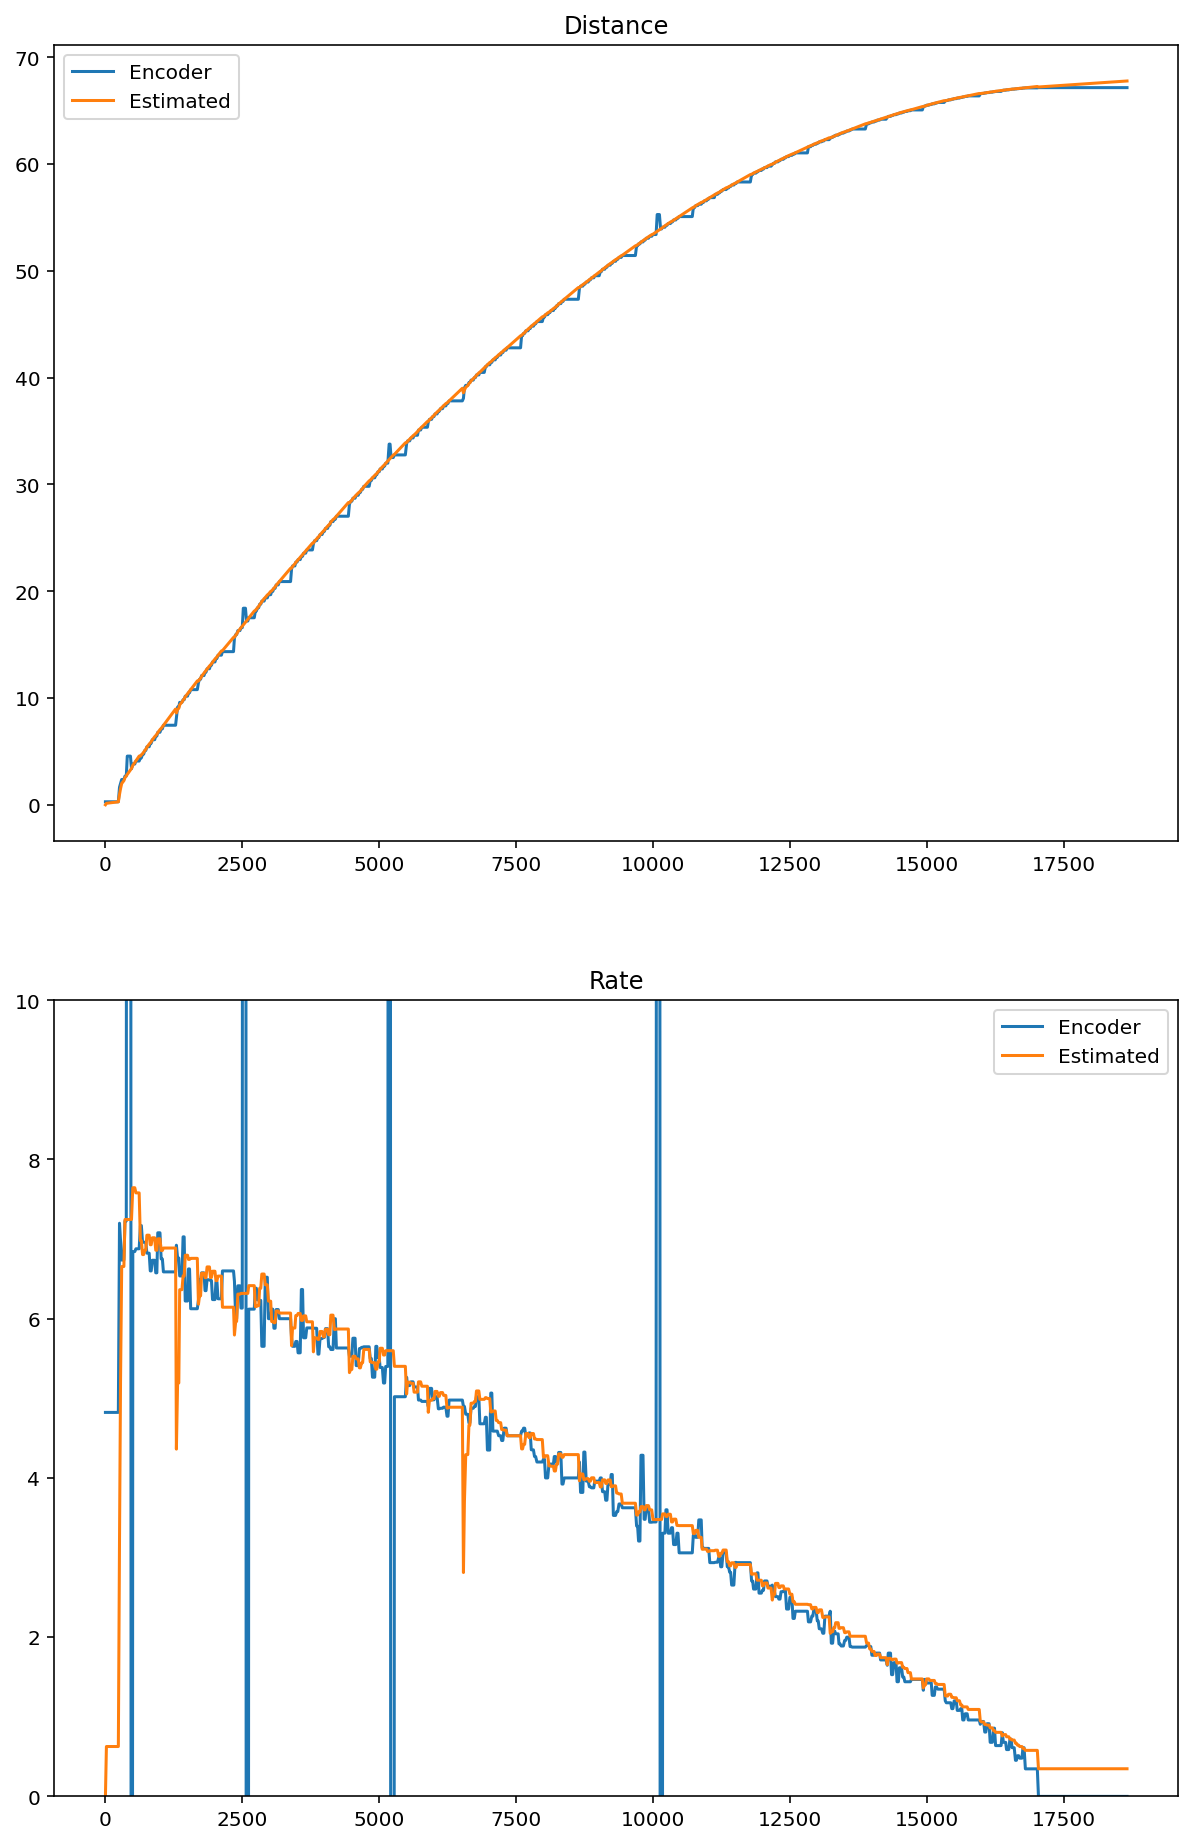

In [90]:
# A simple GH filter based on http://localhost:8888/notebooks/01-g-h-filter.ipynb,
# but throw out outliers great than +- {max_speed} inches/sec
class GHEstimator_LimitSpeed:
    # Initialize model
    lastSampleTime = 0.0
    lastEncDistance = 0.0

    # Current estimates for distance, rate, and acceleration
    estDistance = 0.0
    estRate = 0.0
    estAccel = 0.0

    def __init__(self, *, max_speed, distance_scale, rate_scale):
        self.max_speed = max_speed
        self.distance_scale = distance_scale
        self.rate_scale = rate_scale
    
    def update(self, sampleTime, encoderDistance, encoderRate):
        dt = (sampleTime - self.lastSampleTime) / 1000.0

        # Special case, duplicate time value or initial data.
        if dt == 0:
            self.lastSampleTime = sampleTime
            return

        # Prediction step
        predDistance = self.estDistance + self.estRate * dt
        predRate     = self.estRate # Assume rate is constant
        
        # Determine the quality of the sample
        rateIsGood = abs(encoderRate) < self.max_speed
        haveNewData = encoderDistance != self.lastEncDistance

        # Update step if a new value has arrived and rate is reasonable
        if rateIsGood and haveNewData:
            residual = encoderDistance - predDistance
            
            self.estDistance = predDistance + self.distance_scale * residual
            self.estRate     = predRate     + self.rate_scale     * residual / dt

            self.lastEncDistance = encoderDistance
        else:
            self.estDistance = predDistance
            self.estRate     = predRate

        self.lastSampleTime = sampleTime

f = GHEstimator_LimitSpeed(max_speed=20, distance_scale=0.5, rate_scale=0.04)
data = runGH('data-slow-to-stop.csv', f)
plotEstimates(data=data)

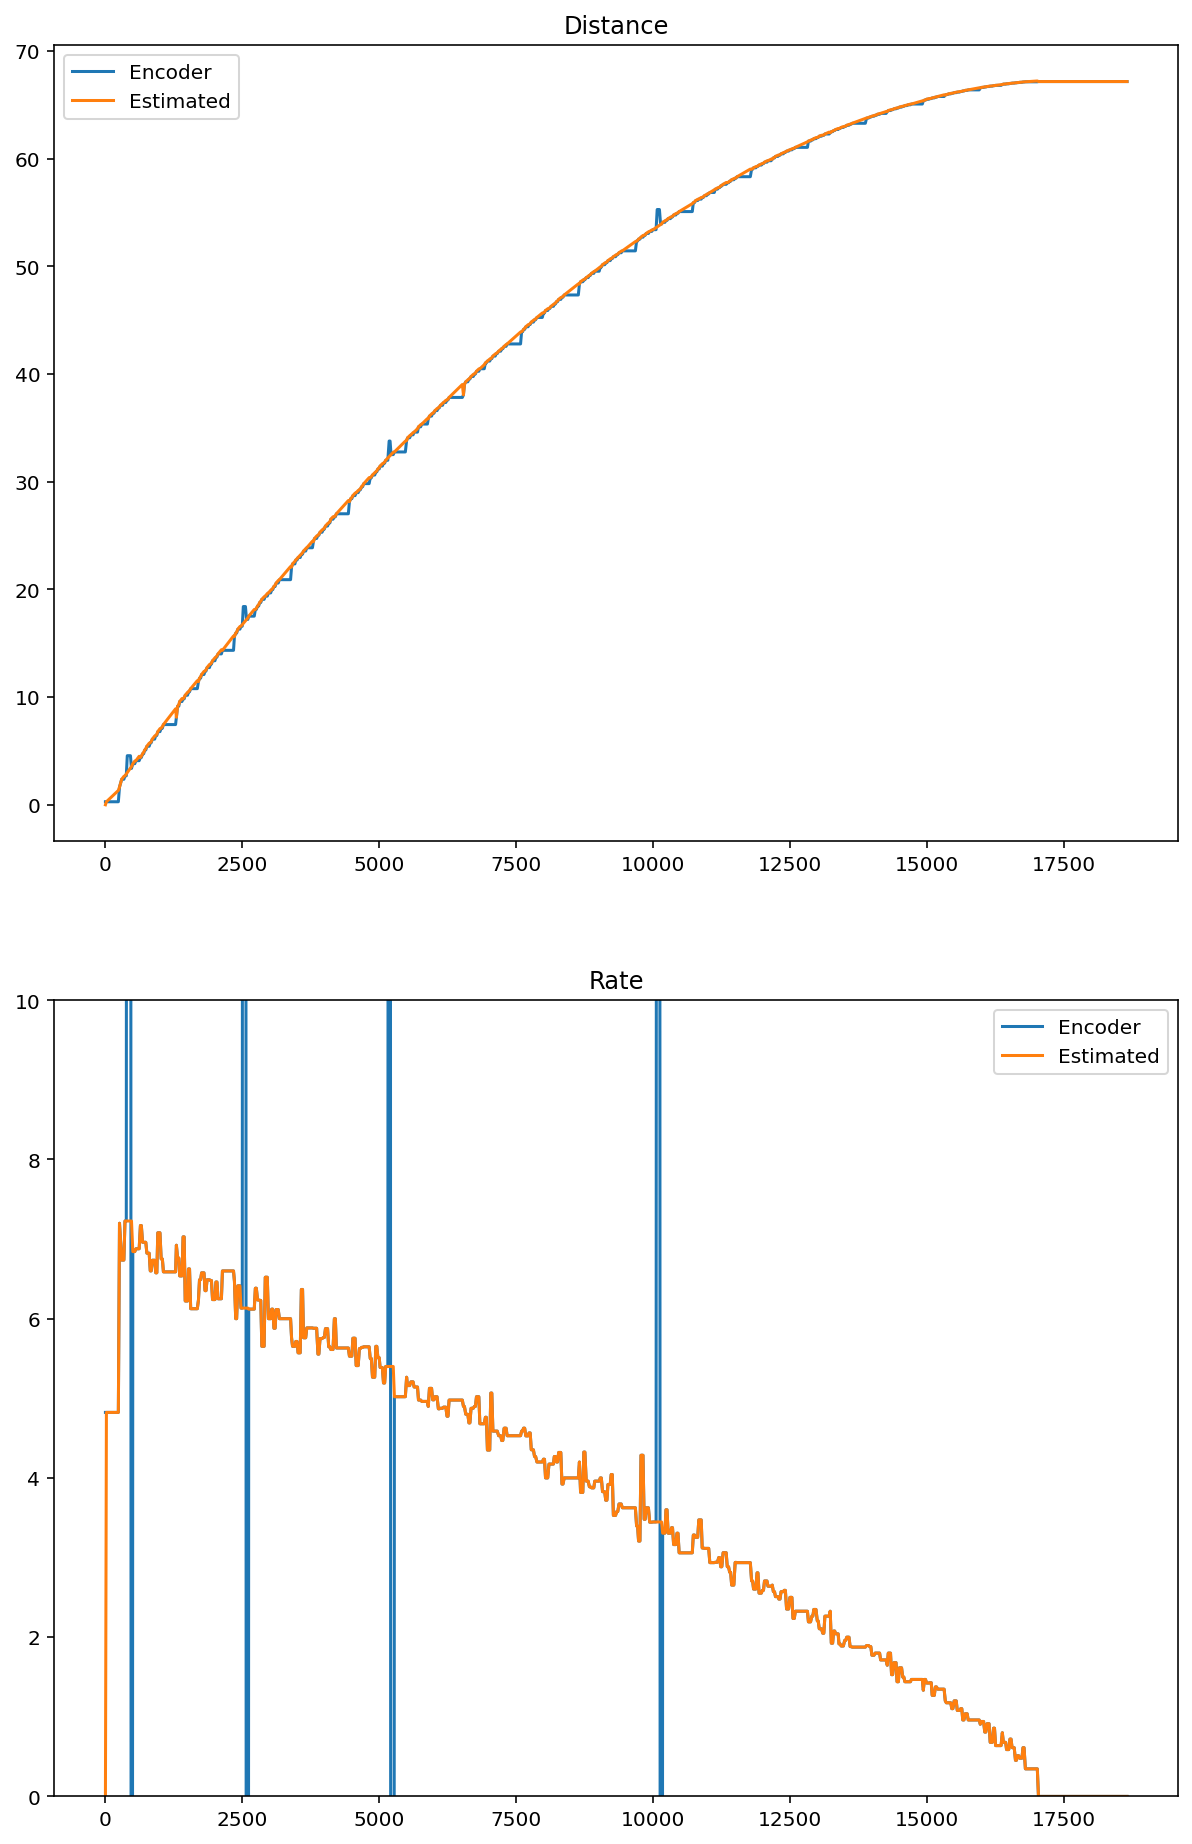

In [97]:
# There are two problems related to the Romi wheel encoders.
#
# 1. The Romi the encoder doesn't always return a new value for distance,
# often the same distance is returned, usually following a 2, 3, 2, 3, ... pattern,
# implying maybe the simulator is only get an update once every 50ms. That means we
# can't always trust the encoder distance.
# 2. The rate reported by the encoder is usually quite good, only a little bit noisy.
# However, there are occasional glitches where the rate is reported super high then
# immediately after super low, before returning to the expected range. These blips
# seems to coincide with some of the times that the encoder distance does actually
# increase, but not every time.
#
# This filter implements the following:
# If the encoder distance changes and the rate is "reasonable" then trust the
# measurement, otherwise trust the prediction.
class TrashCompactor:
    # Initialize model
    lastSampleTime = 0.0
    lastEncDistance = 0.0

    # Current estimates for distance, rate, and acceleration
    estDistance = 0.0
    estRate = 0.0
    estAccel = 0.0

    def __init__(self, *, max_speed):
        self.max_speed = max_speed
    
    def update(self, sampleTime, encoderDistance, encoderRate):
        dt = (sampleTime - self.lastSampleTime) / 1000.0

        # Special case, duplicate time value or initial data.
        if dt == 0:
            self.lastSampleTime = sampleTime
            return

        # Prediction step
        predDistance = self.estDistance + self.estRate * dt
        predRate     = self.estRate # Assume rate is constant
        
        # Determine the quality of the sample
        rateIsGood = abs(encoderRate) < self.max_speed
        haveNewData = encoderDistance != self.lastEncDistance

        # Update step if a new value has arrived and rate is reasonable
        if rateIsGood and haveNewData:
            # Trust the measurement 100% (G and H both 1.0)
            self.estDistance = encoderDistance
            self.estRate = encoderRate
            self.lastEncDistance = encoderDistance
        else:
            # Trust the measurement 0% (G and H both 0.0)
            self.estDistance = predDistance
            self.estRate     = predRate

        self.lastSampleTime = sampleTime

f = TrashCompactor(max_speed=22)
data = runGH('data-slow-to-stop.csv', f)
plotEstimates(data=data)